In [1]:
import cv2
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from skimage.io import imshow

In [2]:
im_0 = cv2.cvtColor(cv2.imread("/home/egor/Downloads/Image__2024-02-27__09-52-19.bmp"), cv2.COLOR_BGR2GRAY)

# Inspection


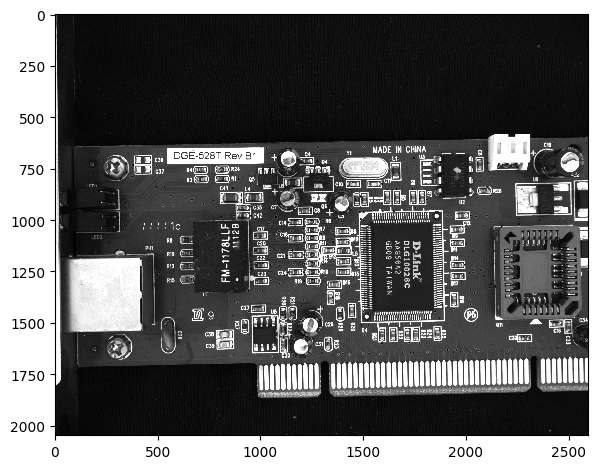

In [3]:
imshow(im_0)

# Image alignment

Image alignment should be done for test image against template image to ensure PCB features match. Alignment is based on SURF algorithm.


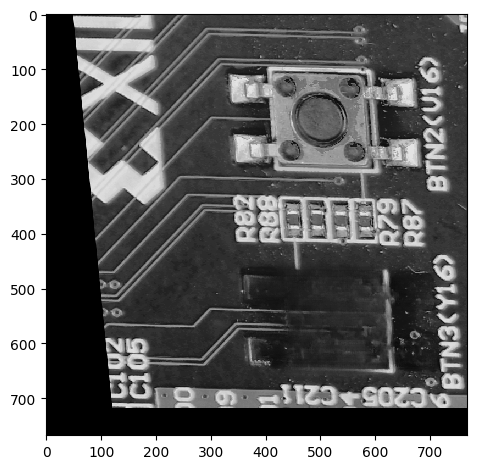

In [ ]:
# GEt template and test image
template = imgs[0].im_original.source
test = imgs[0].im_inpainted.source
rows, cols = test.shape

# Mutate test image to test alignment
# Translation
M = np.float32([[1, 0, 50], [0, 1, 50]])
test = cv2.warpAffine(test, M, test.shape)

# Rotation
M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), 90, 1)
test = cv2.warpAffine(test, M, (cols, rows))

# Affine
pts1 = np.float32([[10, 10], [20, 10], [10, 20]])
pts2 = np.float32([[10, 10], [20, 10], [11, 20]])
M = cv2.getAffineTransform(pts1, pts2)
test = cv2.warpAffine(test, M, (cols, rows))

imshow(test)

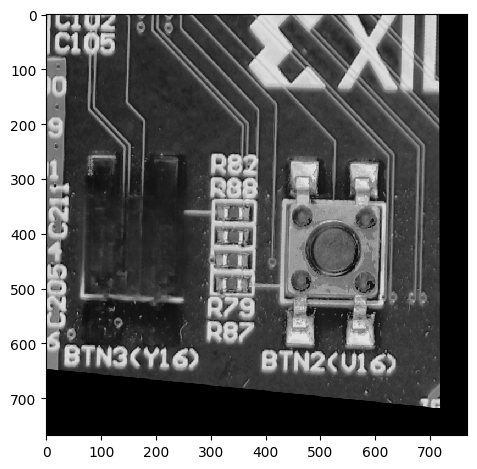

In [ ]:
# use ORB to detect keypoints and extract (binary) local
# invariant features
orb = cv2.ORB_create(100)
(kpsA, descsA) = orb.detectAndCompute(test, None)
(kpsB, descsB) = orb.detectAndCompute(template, None)
# match the features
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.DescriptorMatcher_create(method)
matches = matcher.match(descsA, descsB, None)

# sort the matches by their distance (the smaller the distance,
# the "more similar" the features are)
matches = sorted(matches, key=lambda x: x.distance)
# keep only the top matches
keep = int(len(matches) * 1)
matches = matches[:keep]


# # check to see if we should visualize the matched keypoints
# matchedVis = cv2.drawMatches(test, kpsA, template, kpsB, matches, None)
# # matchedVis = imutils.resize(matchedVis, width=1000)
# imshow(matchedVis)


# allocate memory for the keypoints (x, y)-coordinates from the
# top matches -- we'll use these coordinates to compute our
# homography matrix
ptsA = np.zeros((len(matches), 2), dtype="float")
ptsB = np.zeros((len(matches), 2), dtype="float")
# loop over the top matches
for i, m in enumerate(matches):
    # indicate that the two keypoints in the respective images
    # map to each other
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt

# compute the homography matrix between the two sets of matched
# points
(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
# use the homography matrix to align the images
(h, w) = template.shape[:2]
aligned = cv2.warpPerspective(test, H, (w, h))
# return the aligned image
imshow(aligned)

# Filtering
After bin and XOR

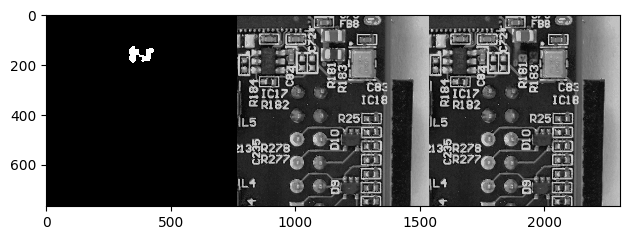

In [77]:
i = 41
im_org = imgs[i].im_original.source
im_inp = imgs[i].im_inpainted.source

# im = cv2.adaptiveThreshold(
#     im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5
# )
# im = cv2.adaptiveThreshold(
#     im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5
# )

value, im_org = cv2.threshold(im_org, 0, 255, cv2.THRESH_OTSU)
value, im_inp = cv2.threshold(im_inp, 0, 255, cv2.THRESH_OTSU)

im_xor = np.logical_xor(im_org, im_inp) * 255
im_xor = im_xor.astype(np.uint8)


def filter(im):
    im = cv2.medianBlur(im, 5)

    kernel = np.ones((5, 5), np.uint8)
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)

    kernel = np.ones((5, 5), np.uint8)
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)

    im = cv2.medianBlur(im, 5)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)

    kernel = np.ones((5, 5), np.uint8)
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)

    kernel = np.ones((1, 1), np.uint8)
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)

    return im


im = filter(im_xor)
im = np.column_stack([im, imgs[i].im_original.source, imgs[i].im_inpainted.source])

imshow(im)

# Filtering

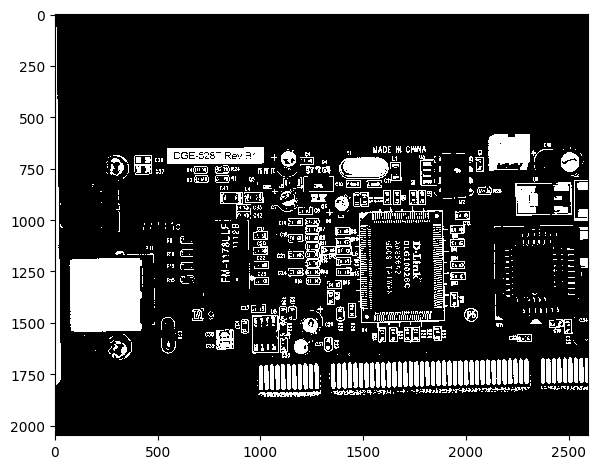

In [5]:
im = im_0

im = cv2.medianBlur(im, 3)
value, im = cv2.threshold(im_0, 0, 255, cv2.THRESH_OTSU)

# im = cv2.medianBlur(im, 5)

# kernel = np.ones((5, 5), np.uint8)
# im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)

# kernel = np.ones((5, 5), np.uint8)
# im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)

# im = cv2.medianBlur(im, 5)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
# im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)

# kernel = np.ones((5, 5), np.uint8)
# im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)

# kernel = np.ones((1, 1), np.uint8)
# im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)

imshow(im)